In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import optuna
from optuna.samplers import TPESampler
from kpi.processor.series_type import type_tag
from kpi.detector.predictors import XGBPredictor, GaussianMixtureDetector, BoxPlotDetector

In [ ]:
# load data
data_path='./data/train.csv'
df=pd.read_csv(data_path)
print('the amount of data:',len(df))
# print(df.head)
# print('Part of missing values for every column')
# print(df.isnull().sum() / len(df))
kpi_ids=pd.unique(df['KPI ID'])
# print(kpi_ids)
kpi_ids=['02e99bd4f6cfb33f' '9bd90500bfd11edb' 'da403e4e3f87c9e0'
 'a5bf5d65261d859a' '18fbb1d5a5dc099d' '09513ae3e75778a3'
 'c58bfcbacb2822d1' '1c35dbf57f55f5e4' '046ec29ddf80d62e'
 '07927a9a18fa19ae' '54e8a140f6237526' 'b3b2e6d1a791d63a'
 '8a20c229e9860d0c' '769894baefea4e9e' '76f4550c43334374'
 'e0770391decc44ce' '8c892e5525f3e491' '40e25005ff8992bd'
 'cff6d3c01e6a6bfa' '71595dd7171f4540' '7c189dd36f048a6c'
 'a40b1df87e3f1c87' '8bef9af9a922e0b3' 'affb01ca2b4f0b45'
 '9ee5879409dccef9' '88cf3a776ba00e7c']

# for kpi_id in kpi_ids:
#     kpi_df=df.loc[df['KPI ID']==kpi_id]
#     print(kpi_id,len(kpi_df))
groups=df.groupby('KPI ID')
# X= np.arange(20)
# X_train, X_test, = train_test_split(X, test_size=0.3, random_state=666)
# print(X_train,X_test)
# X_train, X_test = train_test_split(X, test_size=0.3, shuffle=False)
# print(X_train,X_test)
# for k,df in groups:
#     print(k,len(df),len(df)/(24*60))

No handles with labels found to put in legend.


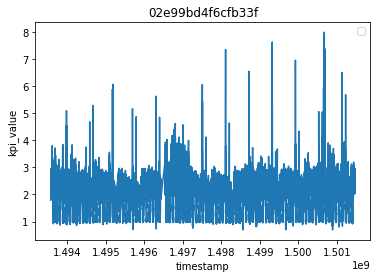

No handles with labels found to put in legend.


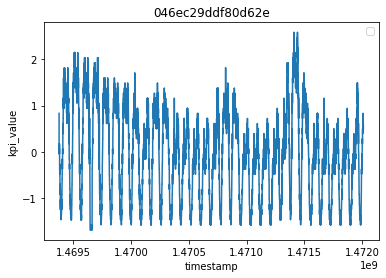

No handles with labels found to put in legend.


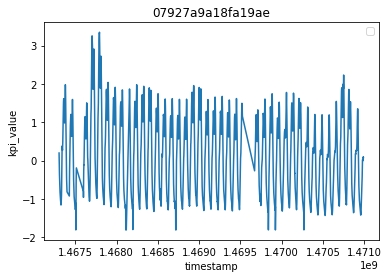

No handles with labels found to put in legend.


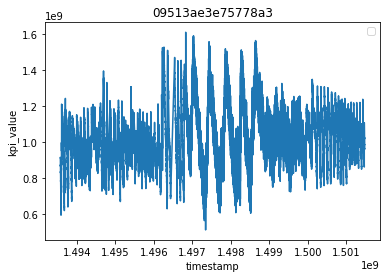

No handles with labels found to put in legend.


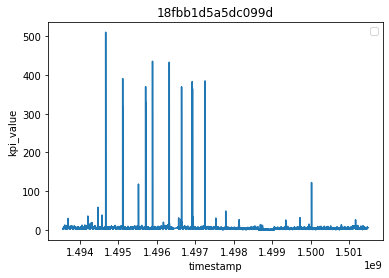

No handles with labels found to put in legend.


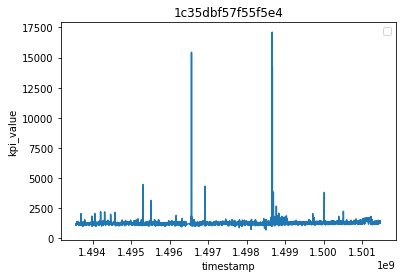

No handles with labels found to put in legend.


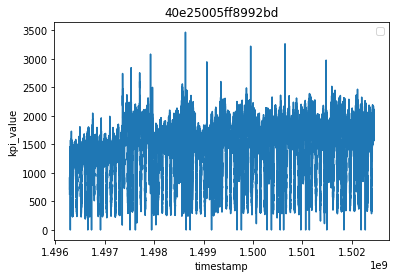

No handles with labels found to put in legend.


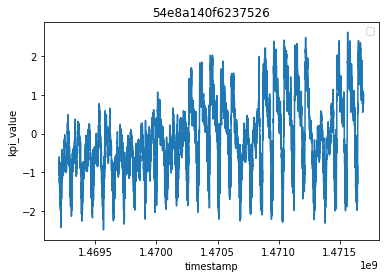

No handles with labels found to put in legend.


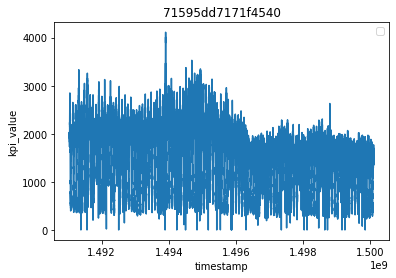

No handles with labels found to put in legend.


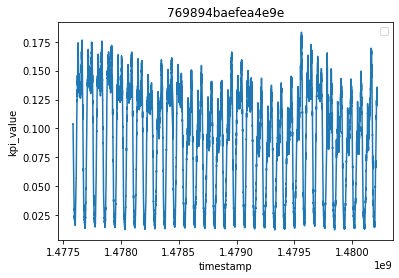

No handles with labels found to put in legend.


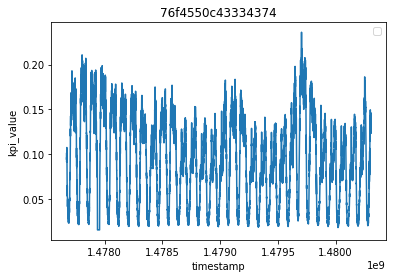

No handles with labels found to put in legend.


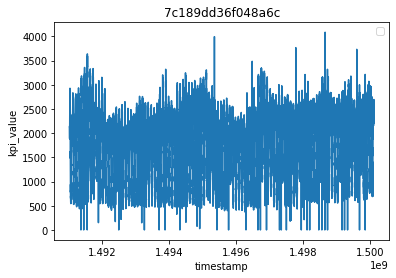

No handles with labels found to put in legend.


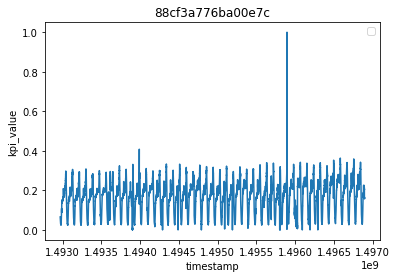

No handles with labels found to put in legend.


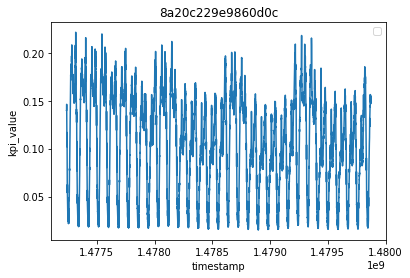

No handles with labels found to put in legend.


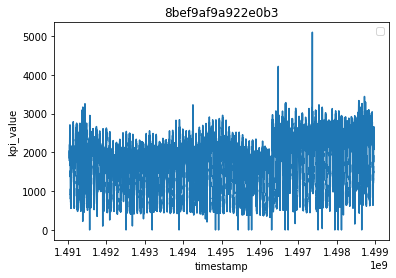

No handles with labels found to put in legend.


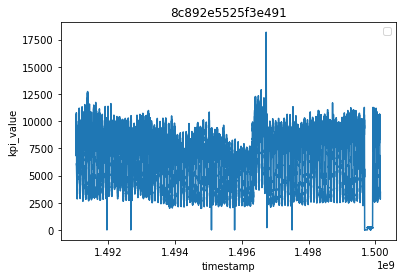

No handles with labels found to put in legend.


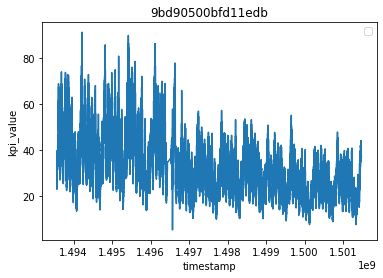

No handles with labels found to put in legend.


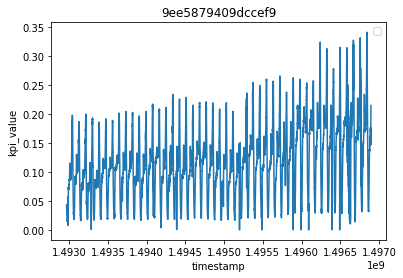

No handles with labels found to put in legend.


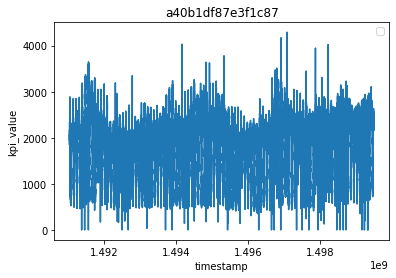

No handles with labels found to put in legend.


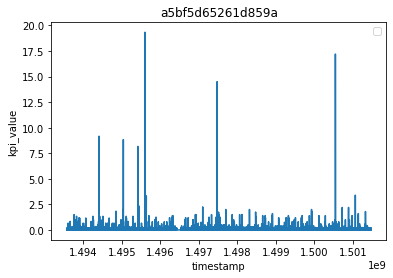

No handles with labels found to put in legend.


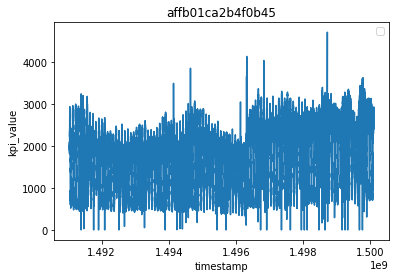

No handles with labels found to put in legend.


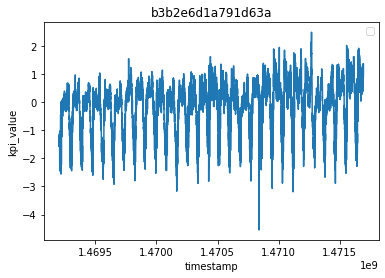

No handles with labels found to put in legend.


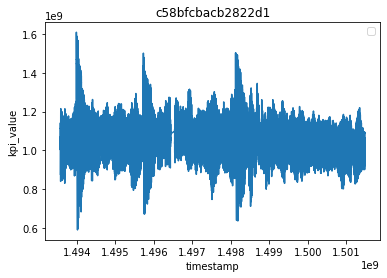

No handles with labels found to put in legend.


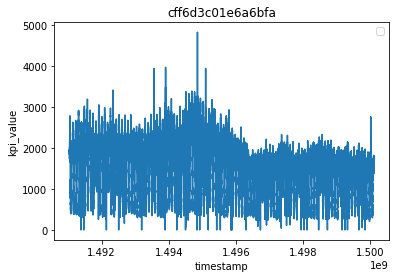

No handles with labels found to put in legend.


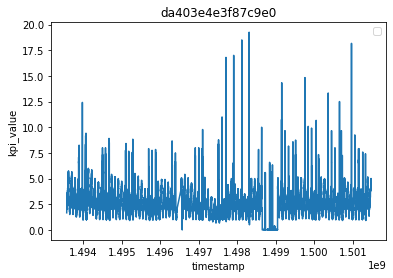

No handles with labels found to put in legend.


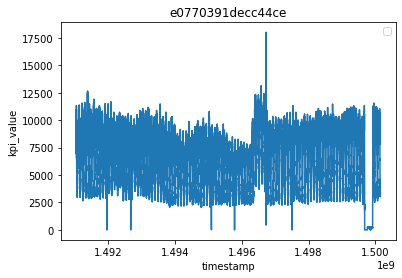

In [5]:
def draw_line(x,y,annotated_points=None,title=None):
    # sub_axix = filter(lambda x:x%200 == 0, x_axix)
    plt.title(title)
    if annotated_points is not None:
        plt.plot(x, y, markevery=annotated_points,marker='o')
    else:
        plt.plot(x, y)
    plt.legend() # 显示图例
    plt.xlabel('timestamp')
    plt.ylabel('kpi_value')
    plt.show()
for k,k_df in groups:
    x,y=k_df['timestamp'],k_df['value']
    # abnormal_points=k_df.where(k_df['label']==1).reset_index().index.tolist()
    # print(abnormal_points)
    # draw_line(x,y,abnormal_points=None,k)
    draw_line(x,y,None,k)

In [8]:
# 超参调优

def create_model(trial):
    num_leaves = trial.suggest_int("num_leaves", 2, 31)
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    model = LGBMClassifier(
        num_leaves=num_leaves,
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        learning_rate=learning_rate,
        feature_fraction=feature_fraction,
        random_state=666
)
    return model

def objective(trial,train_df,test_df):
    model = create_model(trial)
    model.fit(train_df[features], train_df[target])
    score = f1_score(test_df[target].values, model.predict(test_df[features]))
    return score



In [19]:
features = [
        'value','mean', 'var', 'mode','skew','std','max','min','median','cv','rolling_mean', 'rolling_var','rolling_skew','rolling_std','rolling_max','rolling_min','rolling_median','rolling_cv'
    ]
target = 'label'
params = {
'bagging_fraction': 0.5817242323514327,
'feature_fraction': 0.6884588361650144,
'learning_rate': 0.42887924851375825, 
'max_depth': 6,
'min_child_samples': 946, 
'min_data_in_leaf': 47, 
'n_estimators': 169,
'num_leaves': 29,
'random_state': 666
}

In [20]:
# train light-gbm models seperately for differnt kpi ids

def feature_engineering(data):
    mean=data['value'].mean()
    median=data['value'].median()
    var=data['value'].var() #方差
    mode=data['value'].mode()[0] #众数
    max_=data['value'].max()
    min_=data['value'].min()
    std=data['value'].std() #标准差
    skew=data['value'].skew() #偏度
    cv=std/mean #变异度
    rolling_mean=data['value'].rolling(window_size).mean()
    rolling_max=data['value'].rolling(window_size).max()
    rolling_min=data['value'].rolling(window_size).min()
    rolling_var=data['value'].rolling(window_size).var()
    rolling_skew=data['value'].rolling(window_size).skew()
    rolling_std=data['value'].rolling(window_size).std()
    rolling_median=data['value'].rolling(window_size).median()
    rolling_cv=rolling_std/rolling_mean
    data[['mean', 'var', 'mode','skew','std','max','min','median','cv']] = pd.DataFrame([[mean, var, mode,skew,std,max_,min_,median,cv]], index=data.index)
    data['rolling_mean'],data['rolling_var'],data['rolling_skew'],data['rolling_max'],data['rolling_min'],data['rolling_median'],data['rolling_std'],data['rolling_cv']=rolling_mean,rolling_var,rolling_skew,rolling_max,rolling_min,rolling_median,rolling_std,rolling_cv
    return data

# print(len(df))
# kpi_ids=pd.unique(df['KPI ID'])
# print(len(kpi_ids),kpi_ids)

window_size=10 #滑动窗口大小
cnt=0
scores=[]
sampler = TPESampler(seed=666)
for k,k_df in groups:
    # k_df.sample(frac=1.0)
    # k_df.reset_index()
    # train_rate=0.7
    # n_train=int(len(k_df)*train_rate)
    # train_df=k_df.iloc[0:n_train]
    # test_df=k_df.iloc[n_train:]
    # max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
    # k_df[['value']].apply(max_min_scaler)
    k_df=feature_engineering(k_df)
    # values=k_df['value']
    # k_df['diff']=values.diff()
    # k_df.fillna(method='bfill')
    # print(k_df.head(5))
    # train_df, test_df = train_test_split(k_df, random_state=666, test_size=0.2)    
    train_df, test_df = train_test_split(k_df, shuffle=False, test_size=0.3)    
    # study = optuna.create_study(direction="maximize", sampler=sampler)
    # study.optimize(lambda trial:objective(trial,train_df,train_df), n_trials=20)
    # params = study.best_params
    # params['random_state'] = 666
    model = LGBMClassifier(**params)
    model.fit(train_df[features], train_df[target])
    score = f1_score(test_df[target].values, model.predict(test_df[features]))
    print(k,'f1 score: ',score)
    scores.append(score)
print('average f1 score:', np.average(scores))

02e99bd4f6cfb33f f1 score:  0.665750286368843
046ec29ddf80d62e f1 score:  0.0
07927a9a18fa19ae f1 score:  0.06896551724137931
09513ae3e75778a3 f1 score:  0.0
18fbb1d5a5dc099d f1 score:  0.06367924528301887
1c35dbf57f55f5e4 f1 score:  0.8290190735694822
40e25005ff8992bd f1 score:  0.08
54e8a140f6237526 f1 score:  0.0
71595dd7171f4540 f1 score:  0.08431703204047217
769894baefea4e9e f1 score:  0.004454342984409799
76f4550c43334374 f1 score:  0.0
7c189dd36f048a6c f1 score:  0.008547008547008548
88cf3a776ba00e7c f1 score:  0.4102272727272728
8a20c229e9860d0c f1 score:  0.0
8bef9af9a922e0b3 f1 score:  0.07777777777777778
8c892e5525f3e491 f1 score:  0.02609956500724988
9bd90500bfd11edb f1 score:  0.0
9ee5879409dccef9 f1 score:  0.6331763474620618
a40b1df87e3f1c87 f1 score:  0.009328358208955225
a5bf5d65261d859a f1 score:  0.0
affb01ca2b4f0b45 f1 score:  0.0
b3b2e6d1a791d63a f1 score:  0.0
c58bfcbacb2822d1 f1 score:  0.0
cff6d3c01e6a6bfa f1 score:  0.010600706713780918
da403e4e3f87c9e0 f1 scor